In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import os
import random

In [19]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def split_clean_and_augmented(dataset, val_ratio=0.2, exclude_token="augmented"):
    clean_indices = []
    augmented_indices = []

    for i, (path, label) in enumerate(dataset.samples):
        if exclude_token in os.path.normpath(path).split(os.sep):
            augmented_indices.append(i)
        else:
            clean_indices.append(i)

    # Shuffle and split the clean data into train/val
    random.shuffle(clean_indices)
    val_size = int(val_ratio * len(clean_indices))
    val_indices = clean_indices[:val_size]
    train_indices = clean_indices[val_size:] + augmented_indices  # Include augmented only in train

    return Subset(dataset, train_indices), Subset(dataset, val_indices)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load all images (ImageFolder will recurse into subfolders)
dataset = datasets.ImageFolder(root='data', transform=transform)

# Perform the smart split
train_dataset, val_dataset = split_clean_and_augmented(dataset, val_ratio=0.2)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class_names = dataset.classes


In [20]:
class LetterClassifier(nn.Module):
    def __init__(self):
        super(LetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LetterClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 2.1652
Epoch 2, Loss: 1.2226
Epoch 3, Loss: 0.9239
Epoch 4, Loss: 0.7251
Epoch 5, Loss: 0.5899
Epoch 6, Loss: 0.4665
Epoch 7, Loss: 0.3700
Epoch 8, Loss: 0.2739
Epoch 9, Loss: 0.1935
Epoch 10, Loss: 0.1306
Epoch 11, Loss: 0.0814
Epoch 12, Loss: 0.0533
Epoch 13, Loss: 0.0305
Epoch 14, Loss: 0.0281
Epoch 15, Loss: 0.0176
Epoch 16, Loss: 0.0150
Epoch 17, Loss: 0.0142
Epoch 18, Loss: 0.0070
Epoch 19, Loss: 0.0087
Epoch 20, Loss: 0.0116
Epoch 21, Loss: 0.0069
Epoch 22, Loss: 0.0111
Epoch 23, Loss: 0.0061
Epoch 24, Loss: 0.0054
Epoch 25, Loss: 0.0050
Epoch 26, Loss: 0.0031
Epoch 27, Loss: 0.0046
Epoch 28, Loss: 0.0034
Epoch 29, Loss: 0.0023
Epoch 30, Loss: 0.0017
Epoch 31, Loss: 0.0012
Epoch 32, Loss: 0.0018
Epoch 33, Loss: 0.0032
Epoch 34, Loss: 0.0012
Epoch 35, Loss: 0.0021
Epoch 36, Loss: 0.0013
Epoch 37, Loss: 0.0027
Epoch 38, Loss: 0.0665
Epoch 39, Loss: 0.2363
Epoch 40, Loss: 0.0972
Epoch 41, Loss: 0.0274
Epoch 42, Loss: 0.0089
Epoch 43, Loss: 0.0037
Epoch 44, Loss: 0.00

In [22]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 99.16%


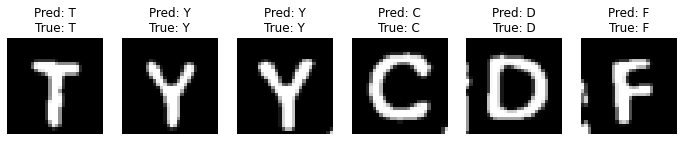

In [23]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

dataiter = iter(val_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 4))
for idx in range(6):
    plt.subplot(1, 6, idx+1)
    imshow(images[idx])
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")


In [24]:
torch.save(model.state_dict(), 'letter_classifier.pth')
